# QCOM Tutorial: Static Eigen-Solve → Target State Vector → Probabilities

This short tutorial shows how to:
1. Build a small system Hamiltonian (In this case Rydberg)
2. Compute a **target eigenstate** (e.g., the ground state)
3. Extract **computational-basis probabilities** from that state
4. (Optional) Save/inspect results

---

## Contents
- [1. Imports & Environment](#1-imports--environment)
- [2. Build a Small Register](#2-build-a-small-register)
- [3. Construct a Hamiltonian](#3-construct-a-hamiltonian)
- [4. Solve for the Target Eigenstate](#4-solve-for-the-target-eigenstate)
- [5. Extract Probabilities in the Computational Basis](#5-extract-probabilities-in-the-computational-basis)
- [6. Inspect / Print Most-Probable Bitstrings](#6-inspect--print-most-probable-bitstrings)
- [7. (Optional) Save / Reload with IO Utilities](#7-optional-save--reload-with-io-utilities)

## 1. Imports & Environment
We use the **Rydberg** builder from `qcom.hamiltonians`, the **static** solver from `qcom.solvers`, and helper utilities from `qcom.metrics`.

In [1]:
import qcom as qc
import numpy as np

## 2. Build a Small Register

We create a tiny 1D register with **N = 3** sites spaced evenly in meters.

- The `LatticeRegister` should provide positions in **SI meters**.
- You can use any geometry you like (line, grid, etc.).

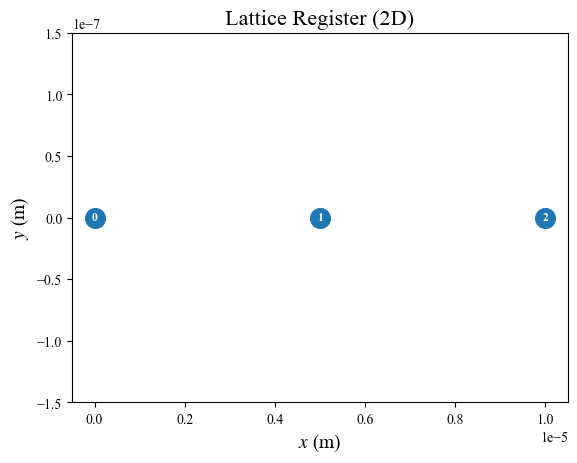

In [11]:
# Three sites (eg: atoms) on a line, 5 micrometers apart
dx = 5e-6
positions = np.array([
    [0.0,     0.0, 0.0],
    [dx,      0.0, 0.0],
    [2*dx,    0.0, 0.0],
], dtype=float)

register = qc.LatticeRegister(positions=positions)
ax = register.plot()  # optional plot of the register

## 3. Construct a Hamiltonian

In this example we’ll use the canonical two-level Rydberg Hamiltonian. This means the sites are more appropriately reffered to as atoms.:

$$
H = \sum_i \frac{\Omega_i}{2}\big[\cos\phi_i\,\sigma_i^x + \sin\phi_i\,\sigma_i^y\big]
    - \sum_i \Delta_i\, n_i
    + \sum_{i<j} V_{ij}\, n_i n_j,\quad n_i=\frac{I-\sigma_i^z}{2}.
$$

**Inputs**
- `C6` in units of **rad·s⁻¹·m⁶**
- `Omega`, `Delta`, `Phi` can be scalar or length-N arrays (broadcast to sites)
- Optional `cutoff` distance (meters) zeros out far interactions

We’ll pick simple, uniform parameters for clarity.

In [12]:
# Physical-ish parameters (toy values so we can run fast on a laptop)
C6    = 2.0e6 * (1e-6)**6      # rad·s^-1·m^6 (purely illustrative, not calibrated)
Omega = 2.0e5                  # rad/s (uniform Rabi)
Delta = 0.0                    # rad/s (on resonance)
Phi   = 0.0                    # radians (no phase → Hermitian real)

H_obj = qc.build_rydberg(
    register,
    C6=C6,
    Omega=Omega,
    Delta=Delta,
    Phi=Phi,
    cutoff=None,               # keep all interactions (set to np.inf to disable interactions)
)

print(H_obj)
print("Hilbert dimension =", H_obj.hilbert_dim)

RydbergHamiltonian(N=3, Omega∈[2.000e+05,2.000e+05], Delta∈[0.000e+00,0.000e+00], phi∈[0.000e+00,0.000e+00])
Hilbert dimension = 8


## 4. Solve for the Target Eigenstate

We’ll compute the **ground state** first (index 0), then show how to grab an excited state as well.

**Under the hood**
- `ground_state(...)` is a convenience wrapper around a sparse Hermitian eigensolver (`eigsh`).
- It operates on a **LinearOperator** abstraction, so we don’t need to build dense matrices for typical usage.

In [4]:
# Ground state (lowest eigenvalue)
e0, v0 = qc.ground_state(H_obj, return_vector=True, show_progress=True)
print("Ground energy (rad/s) =", e0)
print("State vector shape     =", v0.shape)

Starting: Eigen solve...
Completed: Eigen solve. Elapsed time: 0.03 seconds.                             0.00s
Ground energy (rad/s) = -299935.5361497417
State vector shape     = (8,)


#### Getting A Higher State

In [5]:
# Example: get the 2nd excited state (index=2) just to demonstrate API
# (This calls eigsh under the hood and returns the last of k=state_index+1 eigenpairs.)
e2, v2 = qc.find_eigenstate(H_obj, state_index=2, show_progress=True)
print("Eigenvalue @ index 2 (rad/s) =", e2)

Starting: Eigen solve...
Completed: Eigen solve. Elapsed time: 0.00 seconds.                             0.00s
Eigenvalue @ index 2 (rad/s) = -99936.02047999795


## 5. Extract Probabilities in the Computational Basis

We can map the eigenvector amplitudes to **bitstrings** and compute probabilities:
$$
p(b) = |\langle b \mid \psi \rangle|^2,\quad b \in \{0,1\}^N.
$$

We’ll use the convenience `get_eigenstate_probabilities`, which:
- Computes the chosen eigenvector (if you pass a Hamiltonian object)
- Returns a dict `{bitstring: probability}` with bitstrings zero-padded to **N** bits.

In [6]:
# Probability dictionary for the ground state
prob_dict = qc.get_eigenstate_probabilities(H_obj, state_index=0, show_progress=True)

# Sanity check: sum to ~1
total_prob = float(sum(prob_dict.values()))
print("Sum of probabilities =", total_prob)
print("Number of basis states =", len(prob_dict))

Starting: Computing Eigenstate Probabilities...
Completed: Computing Eigenstate Probabilities. Elapsed time: 0.01 seconds.         0.01s | Remaining:    0.00s
Sum of probabilities = 1.0
Number of basis states = 8


## 6. Inspect / Print Most-Probable Bitstrings

For small N, it’s often useful to print the **top-k** bitstrings. We’ll sort and show the top 8.

In [14]:
# Sort (high → low) and print top-k
top_k = 8
# For top-k by probability, sort on value:
top_sorted = sorted(prob_dict.items(), key=lambda kv: kv[1], reverse=True)[:top_k]

print(f"Top {top_k} bitstrings by probability:")
for i, (b, p) in enumerate(top_sorted, 1):
    print(f"{i:2d}. {b}  p={p:.6f}")

# Or use the convenience pretty printer if you like:
print("\nPretty printer:")
qc.print_most_probable_data(prob_dict, n=top_k)

Top 8 bitstrings by probability:
 1. 000  p=0.125121
 2. 100  p=0.125080
 3. 001  p=0.125080
 4. 010  p=0.125041
 5. 101  p=0.125038
 6. 011  p=0.124920
 7. 110  p=0.124920
 8. 111  p=0.124799

Pretty printer:
Top 8 Most probable bit strings:
1.  Bit string: 000, Probability: 0.12512092
2.  Bit string: 100, Probability: 0.12508028
3.  Bit string: 001, Probability: 0.12508028
4.  Bit string: 010, Probability: 0.12504089
5.  Bit string: 101, Probability: 0.12503842
6.  Bit string: 011, Probability: 0.12492031
7.  Bit string: 110, Probability: 0.12492031
8.  Bit string: 111, Probability: 0.12479860


## 7. (Optional) Save / Reload with IO Utilities

You can persist probability dictionaries for later analysis:

- Text format: one line per state → `"<bitstring> <prob>"`
- Parquet format: two columns: `state`, `probability`

This is handy for offline plotting, post-processing, or sharing results.

In [10]:

# --- Save to text ---
save_path = "ground_probs.txt"
# qc.save_data(prob_dict, save_path, show_progress=True)

# --- Load back from text ---
# loaded_counts, total = parse_file(save_path, show_progress=True)
# 'parse_file' yields counts; if probabilities were saved, 'total' may not be 1.0.
# You can renormalize or just treat them as weights.

# --- Save to parquet ---
save_parq_path = "ground_probs.parquet"
# qc.save_dict_to_parquet(prob_dict, save_parq_path)

# --- Load back from parquet ---
# loaded_prob_dict = qc.parse_parquet(save_parq_path)
# print("Loaded from parquet:", len(loaded_prob_dict), "entries; sum=", sum(loaded_prob_dict.values()))